In [6]:
import os
import numpy as np
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt
import h5py as h5
from scipy import signal
import utils
import parser_ops
os.environ["CUDA_VISIBLE_DEVICES"] = "2"#set it to available gpu
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
parser = parser_ops.get_parser()
args = parser.parse_args(args=[])

###  Plot loss curves 

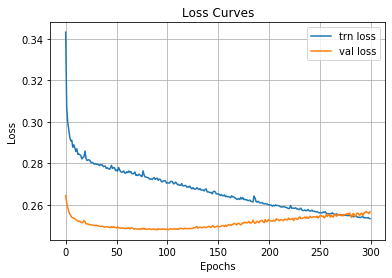

In [7]:
file_dir = os.path.join(os.getcwd(),'saved_models')
saved_model_name = 'ZS_SSL_Rate4_25reps'
saved_model_dir = os.path.join(file_dir,saved_model_name)
trn_loss=sio.loadmat(os.path.join(saved_model_dir,'TrainingLog.mat'))['trn_loss']
val_loss=sio.loadmat(os.path.join(saved_model_dir,'TrainingLog.mat'))['val_loss']
plt.plot(np.asarray(trn_loss).T)
plt.plot(np.asarray(val_loss).T)
plt.title('Loss Curves'), plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.legend(['trn loss', 'val loss'])
plt.grid()
plt.show()


### Load the data and generate images

In [8]:
# load the data, pad the mask and normalize k-space
data = sio.loadmat(args.data_dir) 
kspace_test,sens_maps, original_mask= data['kspace'], data['sens_maps'], data['mask']
nrow_GLOB, ncol_GLOB, ncoil_GLOB  = kspace_test.shape

# %%  zeropadded outer edges of k-space with no signal- check readme file for further explanations
# for coronal PD dataset, first 17 and last 16 columns of k-space has no signal
# in the training mask we set corresponding columns as 1 to ensure data consistency
test_mask = np.complex64(original_mask)
test_mask[ :, 0:17] = np.ones((nrow_GLOB, 17))
test_mask[:, 352:ncol_GLOB] = np.ones((nrow_GLOB, 16))

# Normalize the kspace to 0-1 region
kspace_test= kspace_test / np.max(np.abs(kspace_test[:]))

#generate network input  and reference image
nw_input = utils.sense1(kspace_test * np.tile(test_mask[..., np.newaxis], (1, 1, ncoil_GLOB)),sens_maps)
ref_image = utils.sense1(kspace_test,sens_maps)

### Load the model and perform the reconstruction

In [ ]:
tf.reset_default_graph()
loadChkPoint = tf.train.latest_checkpoint(saved_model_dir)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    new_saver = tf.train.import_meta_graph(saved_model_dir + '/model_test.meta')
    new_saver.restore(sess, loadChkPoint)

    # ..................................................................................................................
    graph = tf.get_default_graph()
    nw_output = graph.get_tensor_by_name('nw_output:0')
    nw_kspace_output = graph.get_tensor_by_name('nw_kspace_output:0')
    mu_param = graph.get_tensor_by_name('mu:0')
    x0_output = graph.get_tensor_by_name('x0:0')
    all_intermediate_outputs = graph.get_tensor_by_name('all_intermediate_outputs:0')

    # ...................................................
    trn_maskP = graph.get_tensor_by_name('trn_mask:0')
    loss_maskP = graph.get_tensor_by_name('loss_mask:0')
    nw_inputP = graph.get_tensor_by_name('nw_input:0')
    sens_mapsP = graph.get_tensor_by_name('sens_maps:0')
    weights = sess.run(tf.global_variables())
    #...................................................
    dataDict = {nw_inputP: utils.complex2real(nw_input)[np.newaxis], trn_maskP: test_mask[np.newaxis], loss_maskP: test_mask[np.newaxis], sens_mapsP: np.transpose(sens_maps[np.newaxis], (0, 3, 1, 2))}
    zs_ssl_recon, *_ = sess.run([nw_output, nw_kspace_output, x0_output, all_intermediate_outputs, mu_param], feed_dict=dataDict)


### Visualize the reconstruction

(<matplotlib.axes._subplots.AxesSubplot at 0x7f28cc057d30>,
 Text(0.5, 1.0, 'ZS-SSL Recon'))

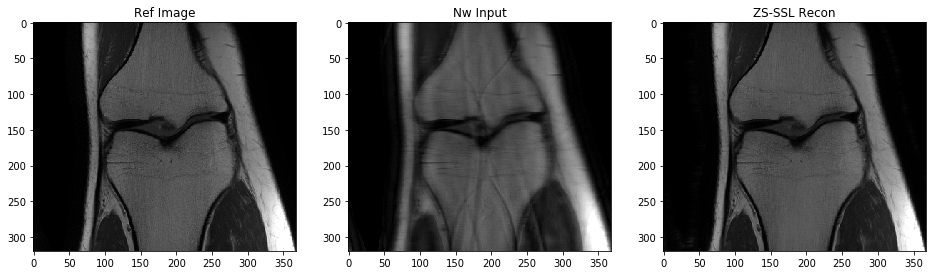

In [10]:
if args.data_opt == 'Coronal_PD':
    """window levelling in presence of fully-sampled data"""
    factor = np.max(np.abs(ref_image[:]))
else:
    factor = 1
zs_ssl_recon = utils.real2complex(zs_ssl_recon.squeeze())
ref_image = np.abs(ref_image) / factor
nw_input = np.abs(nw_input) / factor
zs_ssl_recon = np.abs(zs_ssl_recon) / factor

plt.figure(figsize=(16,16))
plt.subplot(1,3,1),plt.imshow(ref_image,cmap='gray',vmax=0.7*np.max(ref_image[:])), plt.title('Ref Image')
plt.subplot(1,3,2),plt.imshow(nw_input,cmap='gray',vmax=0.7*np.max(ref_image[:])), plt.title('Nw Input')
plt.subplot(1,3,3),plt.imshow(zs_ssl_recon,cmap='gray',vmax=0.7*np.max(ref_image[:])), plt.title('ZS-SSL Recon')
